In [ ]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "02_ml_models/02b_neural_network.ipynb"
_nb_title = "Flowers Image Classification using a neural network"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Flowers Image Classification using a neural network&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F02_ml_models%2F02b_neural_network.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F02_ml_models%2F02b_neural_network.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/02_ml_models/02b_neural_network.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/02_ml_models/02b_neural_network.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/02_ml_models/02b_neural_network.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Flowers Image Classification using a neural network

In this notebook, we show how to build a neural network to classify the tf-flowers dataset.

Much of the data exploration was done in the companion notebook
02a_machine_perception.ipynb


## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
import torch
print(torch.__version__)
device_name = torch.cuda.current_device()
print(f'GPU: {device_name}')

2.5.1+cu121
GPU: 0


In [2]:
# Helper functions
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
def training_plot(history):
    f, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(history['train_loss'])
    ax[0].plot(history['val_loss'], ls='dashed')
    ax[1].plot(history['train_accuracy'])
    ax[1].plot(history['val_accuracy'], ls='dashed')
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[0].legend(['train_loss', 'val_loss'], fontsize=15)
    ax[1].legend(['train_accuracy', 'val_accuracy'], fontsize=15)

# Call model.predict() on a few images in the evaluation dataset
device = "cuda:0"
s = torch.nn.Softmax(dim=1)
def plot_predictions(dataset):
    matplotlib.rcParams.update({'font.size': 14})
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset):
        if idx > 14:
            break
        ax[idx//5, idx%5].imshow((img));
        batch_img = torch.unsqueeze(torch.Tensor(img), 0)
        batch_img = batch_img.to(torch.float64).to(device)
        batch_img
        with torch.no_grad():
            ## forward + loss
            logits = model(batch_img)
            probs = s(logits)
            preds = torch.argmax(probs, dim=1)
        label = CLASS_NAMES[label]
        pred_label = CLASS_NAMES[preds[0]]
        ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, torch.max(probs)))
        ax[idx//5, idx%5].axis('off')

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("batoolabbas91/flower-photos-by-the-tensorflow-team")

print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:02<00:00, 78.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1


In [4]:
import matplotlib.pylab as plt
import numpy as np
import cv2
from glob import glob
import os

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_img(filename, shape):
    img = cv2.imread(filename)
    img = img[..., ::-1]
    img = cv2.resize(img, shape)
    return img.astype(float) / 255

CLASS_NAMES = glob("/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/flower_photos/*")
CLASS_NAMES = [os.path.basename(x) for x in CLASS_NAMES]
CLASS_NAMES = [x for x in CLASS_NAMES  if not '.' in x]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['dandelion', 'sunflowers', 'roses', 'tulips', 'daisy']


In [17]:
# Set seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

In [5]:
# split dataset to train / val
from sklearn.model_selection import train_test_split

data_dir = "/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/"

X = glob(os.path.join(data_dir, "flower_photos/*/*.jpg"))
y = [filename.split('/')[-2] for filename in X]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.10)

In [6]:
import pandas as pd

# save splits
train_df = pd.DataFrame({"path": X_train, "flower": y_train})
val_df = pd.DataFrame({"path": X_val, "flower": y_val})

train_df.to_csv("flowers_train.csv", index=False)
val_df.to_csv("flowers_val.csv", index=False)

In [7]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class FlowersDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_img(img_path, [IMG_HEIGHT, IMG_WIDTH])
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
train_dataset = FlowersDataset("flowers_train.csv", data_dir)
val_dataset = FlowersDataset("flowers_val.csv", data_dir)

# decode_csv changed so that the label is the index into CLASS_NAMES array
def idx_label(label):
  label = np.argmax(np.equal(CLASS_NAMES, label))
  return label

train_dataset.img_labels["flower"] = train_dataset.img_labels["flower"].map(idx_label)
val_dataset.img_labels["flower"] = val_dataset.img_labels["flower"].map(idx_label)

## A Neural Network (NN) model

Adding one non-linear layer in the middle ...

In [9]:
BATCH_SIZE = 32

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

In [10]:
# NN with one hidden layer
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=IMG_HEIGHT*IMG_WIDTH*IMG_CHANNELS,
                    out_features=128),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=128, out_features=5)
)

model = model.to(device)

learning_rate = 1e-4
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
## compute accuracy
def get_accuracy(inputs, target, batch_size):
    ''' Obtain accuracy for training round '''
    accuracy = torch.sum(inputs == target) / batch_size
    return accuracy.item()

In [ ]:
# train loop
num_epochs = 10

history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

model = model.to(dtype=torch.float64)

for epoch in range(num_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_loss += loss.detach().item()

        probs = s(logits)
        inputs = torch.argmax(probs, dim=1)
        train_accuracy += get_accuracy(inputs, labels, BATCH_SIZE)

    history['train_loss'].append(train_loss / i)
    history['train_accuracy'].append(train_accuracy/i)
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_loss / i, train_accuracy / i))

    ## validation step
    model.eval()
    for i, (images, labels) in enumerate(valloader):

        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            ## forward + loss
            logits = model(images)
            loss = criterion(logits, labels)

            val_loss += loss.detach().item()

            probs = s(logits)
            inputs = torch.argmax(probs, dim=1)
            val_accuracy += get_accuracy(inputs, labels, BATCH_SIZE)

    history['val_loss'].append(val_loss / i)
    history['val_accuracy'].append(val_accuracy/i)

Epoch: 0 | Loss: 1.5501 | Train Accuracy: 0.38
Epoch: 1 | Loss: 1.3151 | Train Accuracy: 0.45
Epoch: 2 | Loss: 1.2189 | Train Accuracy: 0.50
Epoch: 3 | Loss: 1.1928 | Train Accuracy: 0.51
Epoch: 4 | Loss: 1.1345 | Train Accuracy: 0.55
Epoch: 5 | Loss: 1.1055 | Train Accuracy: 0.56
Epoch: 6 | Loss: 1.0445 | Train Accuracy: 0.60
Epoch: 7 | Loss: 1.0364 | Train Accuracy: 0.60
Epoch: 8 | Loss: 1.0472 | Train Accuracy: 0.59
Epoch: 9 | Loss: 1.0023 | Train Accuracy: 0.61


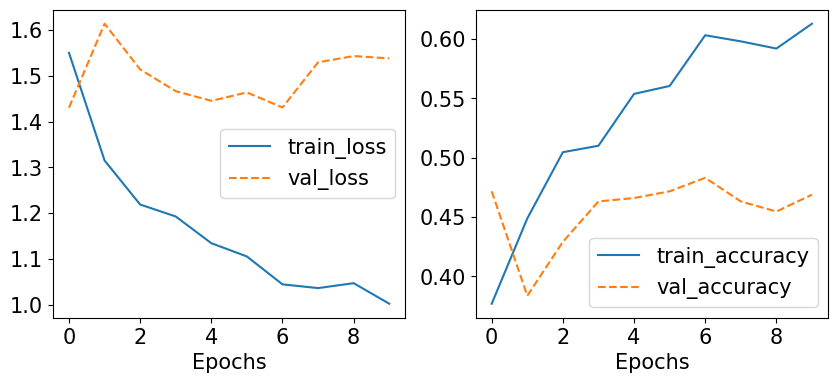

In [ ]:
training_plot(history);

### train functions

In [19]:
def train_loop(model,
               trainloader,
               valloader,
               criterion,
               optimizer,
               num_epochs=10,
               l1=0,
               l2=0
               ):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    model = model.to(dtype=torch.float64)

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        val_loss = 0.0
        val_accuracy = 0.0

        model = model.train()

        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Apply L1 regularization
            if l1 > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1 * l1_norm

            # Apply L2 regularization
            elif l2 > 0:
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += l2 * l2_norm

            optimizer.zero_grad()
            loss.backward()

            ## update model params
            optimizer.step()

            train_loss += loss.detach().item()

            probs = s(logits)
            inputs = torch.argmax(probs, dim=1)
            train_accuracy += get_accuracy(inputs, labels, BATCH_SIZE)

        history['train_loss'].append(train_loss / i)
        history['train_accuracy'].append(train_accuracy/i)
        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
            %(epoch, train_loss / i, train_accuracy / i))

        ## validation step
        model.eval()
        for i, (images, labels) in enumerate(valloader):

            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                ## forward + loss
                logits = model(images)
                loss = criterion(logits, labels)

                val_loss += loss.detach().item()

                probs = s(logits)
                inputs = torch.argmax(probs, dim=1)
                val_accuracy += get_accuracy(inputs, labels, BATCH_SIZE)

        history['val_loss'].append(val_loss / i)
        history['val_accuracy'].append(val_accuracy/i)

    return history

In [16]:
# history = train_loop(model, trainloader, valloader, 10)

In [21]:
# parameterize to the values in the previous cell
def train_and_evaluate(trainloader,
                       valloader,
                       num_epochs=10,
                       batch_size = 32,
                       lrate = 1e-3, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128
                       ):

    # NN with one hidden layers
    model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=IMG_HEIGHT*IMG_WIDTH*IMG_CHANNELS,
                        out_features=num_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=num_hidden, out_features=5)
    )

    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

    history = train_loop(model, trainloader, valloader, criterion, optimizer, num_epochs, l1=l1, l2=l2)
    training_plot(history)
    return model

### tune

Epoch: 0 | Loss: 1.7460 | Train Accuracy: 0.33
Epoch: 1 | Loss: 1.3564 | Train Accuracy: 0.41
Epoch: 2 | Loss: 1.2867 | Train Accuracy: 0.45
Epoch: 3 | Loss: 1.2067 | Train Accuracy: 0.50
Epoch: 4 | Loss: 1.1893 | Train Accuracy: 0.51
Epoch: 5 | Loss: 1.1683 | Train Accuracy: 0.52
Epoch: 6 | Loss: 1.1214 | Train Accuracy: 0.54
Epoch: 7 | Loss: 1.1069 | Train Accuracy: 0.55
Epoch: 8 | Loss: 1.0634 | Train Accuracy: 0.58
Epoch: 9 | Loss: 1.0484 | Train Accuracy: 0.59


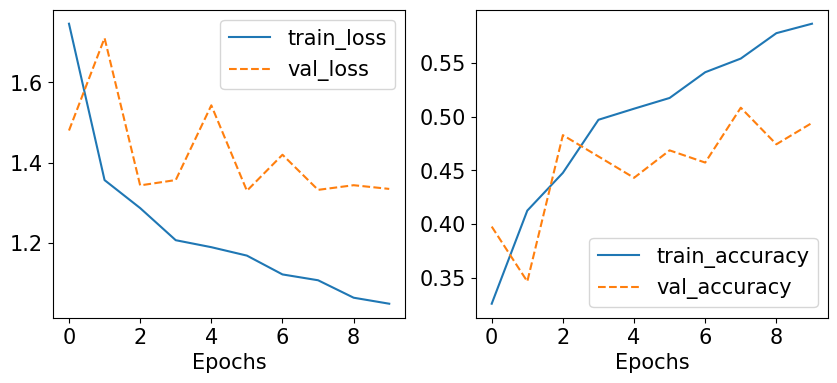

In [23]:
history = train_and_evaluate(trainloader, valloader, batch_size=32, lrate=1e-4, num_hidden=128)

Epoch: 0 | Loss: 1.8004 | Train Accuracy: 0.37
Epoch: 1 | Loss: 1.2840 | Train Accuracy: 0.45
Epoch: 2 | Loss: 1.2255 | Train Accuracy: 0.49
Epoch: 3 | Loss: 1.1766 | Train Accuracy: 0.52
Epoch: 4 | Loss: 1.1494 | Train Accuracy: 0.54
Epoch: 5 | Loss: 1.1285 | Train Accuracy: 0.53
Epoch: 6 | Loss: 1.0820 | Train Accuracy: 0.57
Epoch: 7 | Loss: 1.0505 | Train Accuracy: 0.58
Epoch: 8 | Loss: 1.0041 | Train Accuracy: 0.61
Epoch: 9 | Loss: 0.9883 | Train Accuracy: 0.61


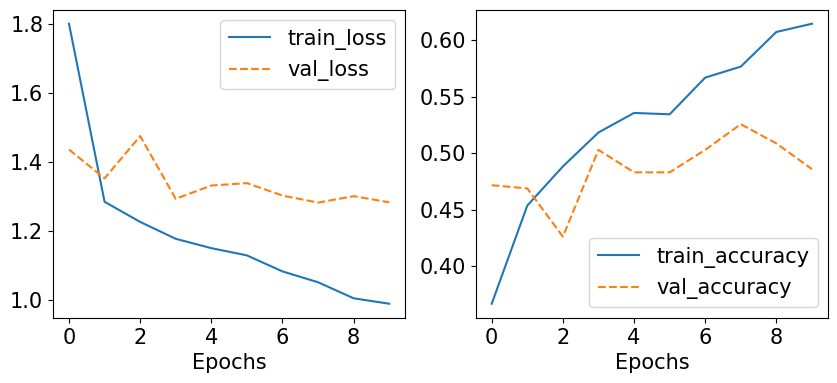

In [22]:
history = train_and_evaluate(trainloader, valloader, batch_size=32, lrate=1e-4, num_hidden=256)

Epoch: 0 | Loss: 6.6472 | Train Accuracy: 0.32
Epoch: 1 | Loss: 1.8888 | Train Accuracy: 0.40
Epoch: 2 | Loss: 1.5818 | Train Accuracy: 0.45
Epoch: 3 | Loss: 1.4890 | Train Accuracy: 0.44
Epoch: 4 | Loss: 1.4378 | Train Accuracy: 0.43
Epoch: 5 | Loss: 1.4164 | Train Accuracy: 0.46
Epoch: 6 | Loss: 1.4483 | Train Accuracy: 0.45
Epoch: 7 | Loss: 1.3840 | Train Accuracy: 0.47
Epoch: 8 | Loss: 1.2592 | Train Accuracy: 0.51
Epoch: 9 | Loss: 1.3158 | Train Accuracy: 0.50


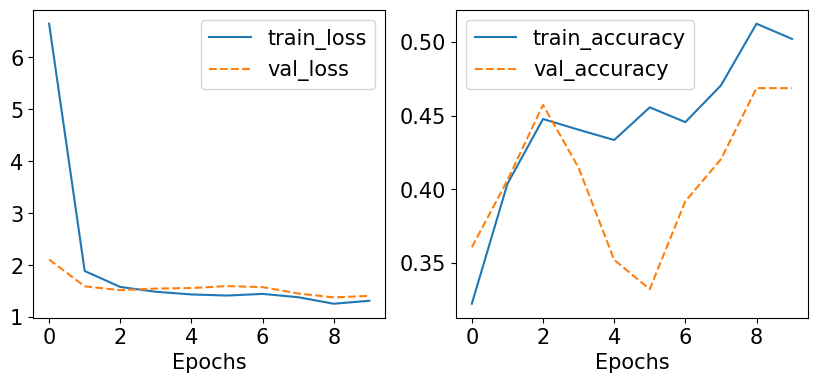

In [24]:
history = train_and_evaluate(trainloader, valloader, batch_size=32, lrate=1e-3, l2=1e-3, num_hidden=128)

## Hyperparameter tuning

In [25]:
!pip install ray[tune] torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 13.1 MB/s eta 0:00:00


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune.schedulers import ASHAScheduler

In [29]:
config = {
    "l1": tune.choice([0]),
    "l2": tune.choice([0.0, 1e-1, 1e-2, 1e-3, 1e-4]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "num_hidden": tune.choice(list(np.arange(32, 256, 32)))
}

In [34]:
def train_flowers(config):
    history = train_and_evaluate(trainloader, valloader, num_epochs=2, batch_size=32, lrate=config["lr"], num_hidden=config["num_hidden"])

In [35]:
result = tune.run(
    train_flowers,
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=2
)

print("Best config: ", result.get_best_config(metric="loss", mode="min"))

+----------------------------------------------------------------------+
| Configuration for experiment     train_flowers_2024-12-22_12-54-30   |
+----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator               |
| Scheduler                        FIFOScheduler                       |
| Number of trials                 2                                   |
+----------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_flowers_2024-12-22_12-54-30
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-12-22_12-42-52_585120_860/artifacts/2024-12-22_12-54-30/train_flowers_2024-12-22_12-54-30/driver_artifacts`

Trial status: 2 PENDING
Current time: 2024-12-22 12:54:30. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------

2024-12-22 12:56:09,203	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-12-22 12:56:09,208	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_flowers_2024-12-22_12-54-30' in 0.0030s.
2024-12-22 12:56:09,214	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2024-12-22 12:56:09,218	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- train_flowers_e28fe_00000: FileNotFoundError('Could not fetch metrics for train_flowers_e28fe_00000: both result.json and progress.csv were not found at /root/ray_results/train_flowers_2024-12-22_12-54-30/train_flowers_e28fe_00000_0_l1=0,l2=0.0100,lr=0.0018,num_hidden=ref_ph_8a3b130c_2024-12-22_12-54-30')
- tra

Trial status: 2 PENDING
Current time: 2024-12-22 12:56:09. Total running time: 1min 38s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------+
| Trial name                  status       l1      l2           lr     num_hidden |
+---------------------------------------------------------------------------------+
| train_flowers_e28fe_00000   PENDING       0   0.01    0.00175382            128 |
| train_flowers_e28fe_00001   PENDING       0   0.001   0.0162463             160 |
+---------------------------------------------------------------------------------+

Best config:  None


In [32]:
print("Best config: ", result.get_best_config(metric="loss", mode="min"))

NameError: name 'result' is not defined

The best set of hyperparameters:
* l2=0, lrate=0.00017, num_hidden=64 score=0.4595

## Deep Neural Network

Let's train a DNN.
We will parameterize the number of layers, and the
number of nodes in each layer

In [ ]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
  ...
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 1298s 12s/step - loss: 1.8584 - accuracy: 0.3142 - val_loss: 1.6154 - val_accuracy: 0.3703
Epoch 2/10
104/104 [==============================] - 394s 4s/step - loss: 1.6173 - accuracy

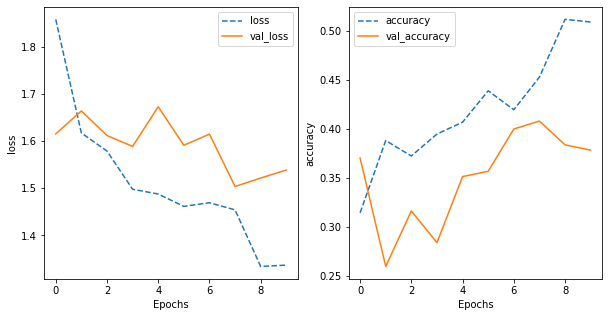

In [ ]:
# model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden = [64, 16])

### Dropout and batchnorm
Add a dropout and batchnorm layer after each of the hidden layers.


In [ ]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       dropout_prob = 0.4,
                       num_hidden = [64, 16]):
  ...
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
batchnorm_dense_0 (BatchNorm (None, 64)                128       
_________________________________________________________________
relu_dense_0 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_dense_0 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
batchnorm_dense_1 (BatchNorm (None, 16)      

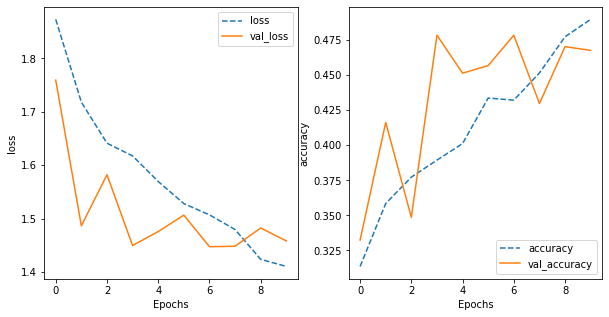

In [ ]:
model = train_and_evaluate(dropout_prob=0.4)